# SMCNOD
This notebook presents the mixture model of 3 gaussians built for SMCNOD data. The data is taken from the S5 Collaboration. With quality cut, we obtained 371 stars with good measurements to feed the model. The mixture model is built with 16 parameters, including radial velocity, metallicity and proper motion parameters of the smcnod and a set of parameters for the background components. We fit a Gaussian mixture model to this data using `emcee`.

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

## SMCNOD Data

In [2]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut

In [3]:
len(tab)

291

In [4]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

Text(0.5, 0, 'pmdec')

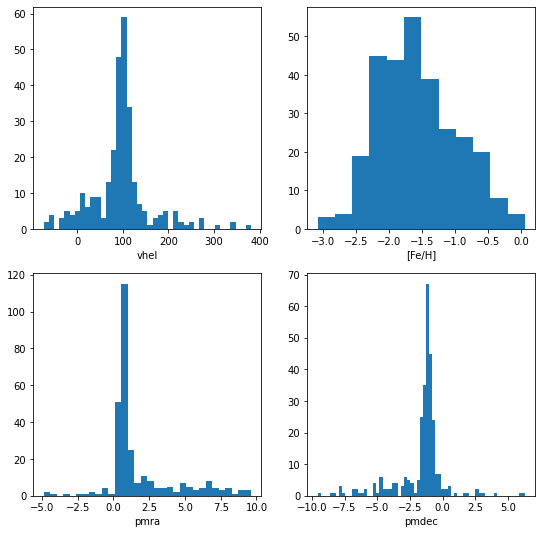

In [5]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
axes[0,0].hist(rv, bins='auto');
axes[0,0].set_xlabel("vhel")
axes[0,1].hist(feh, bins='auto');
axes[0,1].set_xlabel("[Fe/H]")
axes[1,0].hist(pmra, bins='auto');
axes[1,0].set_xlabel("pmra")
axes[1,1].hist(pmdec, bins='auto');
axes[1,1].set_xlabel("pmdec")

In the given code, pmnorm is defined as 1/(np.pi * pmmax**2), where pmmax is the magnitude of the maximum proper motion vector. This expression is used to normalize the proper motion likelihood function for the entire data set.

In more detail, the proper motion likelihood function represents the probability of observing a particular proper motion vector for a star, given its position on the sky and any other relevant information. In this code, a uniform background distribution is assumed, which means that the likelihood of observing any particular proper motion vector is assumed to be constant across the entire sky.

To normalize the proper motion likelihood function, the maximum value of the proper motion vector magnitude is computed (pmmax), and the inverse of the product of pi and the square of pmmax is taken (1/(np.pi * pmmax**2)). This value (pmnorm) is then used to scale the proper motion likelihood function so that its integral over the entire sky is equal to one. This ensures that the probability of observing any proper motion vector is properly normalized, given the assumptions made in the analysis.

In [6]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
# pms array is computed and assigned to the variable pmmax. 
# This is essentially finding the magnitude of the maximum proper motion vector.
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
# normalize the proper motion likelihood function for the entire data set
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]

We will model the smcnod data as a mixture of 3 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pbg1 = fraction of stars in the 1st background component
* pmra = Heliocentric proper motion, RA of the galaxy in mas/yr
* pmdec = Heliocentric proper motion, Dec of the galaxy in mas/yr
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component
* vbg2, lsigvbg2, fehbg2, lsigfeh2 = same parameters for 2nd background component

In total there are 16 parameters.

# Likelihood function

In [7]:
#use a dictionary to store data, make the code more organized, easier to read, and more flexible.
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [8]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2",
                "pmra","pmdec",
                "pmra1","pmdec1","lsigpmra1","lsigpmdec1",
                "pmra2","pmdec2","lsigpmra2","lsigpmdec2"]
def full_like(theta):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal, pmra1, pmdec1, lsigpmra1, lsigpmdec1, \
    pmra2, pmdec2, lsigpmra2, lsigpmdec2 = theta
    
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50) or (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2) or \
        (abs(pmra1) > 10) or (abs(pmdec1) > 10) or (abs(pmra2) > 10) or (abs(pmdec2) > 10) or \
        (lsigpmra1 > 1.3) or (lsigpmra1 < -1) or (lsigpmra2 > 1.3) or (lsigpmra2 < -1) or \
        (lsigpmdec1 > 1.3) or (lsigpmdec1 < -1) or (lsigpmdec2 > 1.3) or (lsigpmdec2 < -1):
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    # Compute log likelihood in proper motions
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]
    lbg1_pmra = stats.norm.logpdf(pmra, loc=pmra1, scale=np.sqrt(pmraerr**2 + (10**lsigpmra1)**2))
    lbg1_pmdec = stats.norm.logpdf(pmdec, loc=pmdec1, scale=np.sqrt(pmdecerr**2 + (10**lsigpmdec1)**2))
    lbg2_pmra = stats.norm.logpdf(pmra, loc=pmra2, scale=np.sqrt(pmraerr**2 + (10**lsigpmra2)**2))
    lbg2_pmdec = stats.norm.logpdf(pmdec, loc=pmdec2, scale=np.sqrt(pmdecerr**2 + (10**lsigpmdec2)**2))
    
    # Combine the components
    lgal = np.log(pgal)+lgal_vhel+lgal_pm+lgal_feh
    lbg1 = np.log(pbg1)+lbg1_vhel+lbg1_pmra+lbg1_pmdec+lbg1_feh
    lbg2 = np.log(1-pbg1)+lbg2_vhel+lbg2_pmra+lbg2_pmdec+lbg2_feh
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal)+lbgtot)
    return ltot.sum()

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [16]:
def project_model(theta, rvmin=-100, rvmax=400, fehmin=-3, fehmax=0):
    """ Turn parameters into rv and feh distributions """
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    params = get_paramdict(theta)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    return rvarr, prv0, prv1, prv2,feharr, pfe0, pfe1, pfe2

In [9]:
def project_model_pm(theta, pmramin=-5, pmramax=10, pmdecmin=-10, pmdecmax=5):
    """ Turn parameters into pmra and pmdec distributions """
    pmraarr = np.linspace(pmramin, pmramax, 1000)
    pmdecarr = np.linspace(pmdecmin, pmdecmax, 1000)
    params = get_paramdict(theta)
    
    ppmra0 = params["pgal"]*stats.norm.pdf(pmraarr, loc=params["pmra"])
    ppmra1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(pmraarr, loc=params["pmra1"], scale=10**params["lsigpmra1"])
    ppmra2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(pmraarr, loc=params["pmra2"], scale=10**params["lsigpmra2"])
    
    ppmdec0 = params["pgal"]*stats.norm.pdf(pmdecarr, loc=params["pmdec"])
    ppmdec1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(pmdecarr, loc=params["pmdec1"], scale=10**params["lsigpmdec1"])
    ppmdec2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(pmdecarr, loc=params["pmdec2"], scale=10**params["lsigpmdec2"])
    return pmraarr, ppmra0, ppmra1, ppmra2,pmdecarr, ppmdec0, ppmdec1, ppmdec2

In [62]:
def plot_1d_distrs(theta):
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)
    model_output_pm = project_model_pm(theta)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Plot 1
    ax = axes[0, 0]
    ax.hist(rv, density=True, color='grey', bins=200)
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="vhel (km/s)", ylabel="Prob. Density")
    ax.legend(fontsize='small')

    # Plot 2
    ax = axes[0, 1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")

    # Plot 3
    ax = axes[1, 0]
    ax.hist(pms[:,0], density=True, color='grey', bins=200)
    xp, p0, p1, p2 = model_output_pm[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="pmra", ylabel="Prob. Density")
    ax.legend(fontsize='small')

    # Plot 4
    ax = axes[1, 1]
    ax.hist(pms[:,1], density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output_pm[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="pmdec", ylabel="Prob. Density")
    ax.legend(fontsize='small')
    return fig

In [45]:
def plot_2d_distr(theta):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    # First subplot
    ax1 = axs[0]
    ax1.plot(feh, rv, 'k.')
    ax1.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax1.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999, label="gal")
    ax1.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999, label="bg1")
    ax1.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999, label="bg2")
    ax1.legend(fontsize='small')
    ax1.grid()

    # Second subplot
    ax2 = axs[1]
    ax2.plot(pms[:,0],pms[:,1], 'k.')
    ax2.set(xlabel="pmra", ylabel="pmdec")#, xlim=[0, 2], ylim=[-2, 0]
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax2.plot(params["pmra"], params["pmdec"], color=colors[0], marker='o',zorder=9999, label="gal")
    ax2.errorbar(params["pmra1"], params["pmdec1"],
               xerr=2*10**params["lsigpmra1"], yerr=2*10**params["lsigpmdec1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999, label="bg1")
    ax2.errorbar(params["pmra2"], params["pmdec2"],
               xerr=2*10**params["lsigpmra2"], yerr=2*10**params["lsigpmdec2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999, label="bg2")
    ax2.legend(fontsize='small')
    ax2.grid()

    plt.tight_layout()


# Optimize parameters



In [ ]:
# posterior from SMCNOD_PM_1DModel-NormalBG
pgal 0.559 0.033
pbg1 0.104 0.031
vhel 98.823 1.291
lsigv 1.147 0.032
feh -1.864 0.029
lsigfeh -0.506 0.035
vbg1 196.791 8.435
lsigvbg1 1.497 0.206
fehbg1 -2.037 0.170
lsigfeh1 -0.386 0.305
vbg2 46.104 3.643
lsigvbg2 2.008 0.030
fehbg2 -1.012 0.051
lsigfeh2 -0.308 0.034
pmra 0.713 0.020
pmdec -1.129 0.020
lsigpmra -0.921 0.065
lsigpmdec -0.913 0.072
pmra1 0.753 0.121
pmdec1 -1.057 0.116
lsigpmra1 -0.653 0.233
lsigpmdec1 -0.572 0.182
pmra2 3.435 0.296
pmdec2 -2.368 0.259
lsigpmra2 0.511 0.032
lsigpmdec2 0.465 0.028

In [46]:
p0_guess = [0.47, 0.57,
            102, 1.3, -1.9,-0.5,
            140, 2.0, -1.3, -0.37,
            27, 1.6, -0.7, -0.5,
            0.7, -1.1,
            0.7, -1, -0.5, -0.5,
            3, -2, 0.5, 0.5]

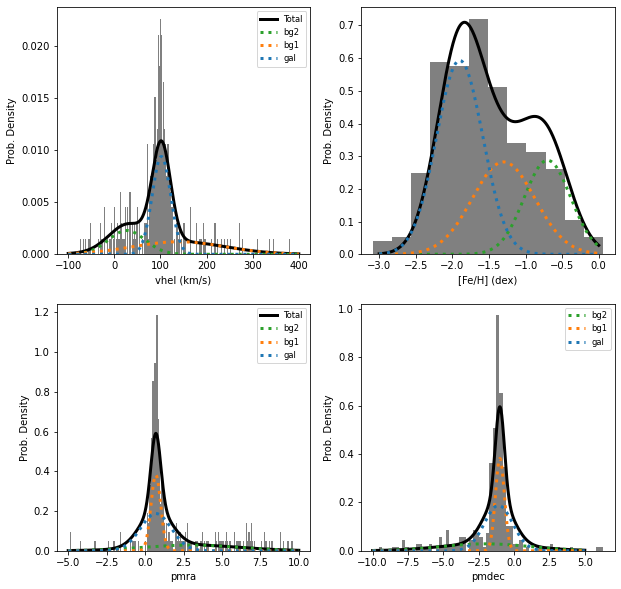

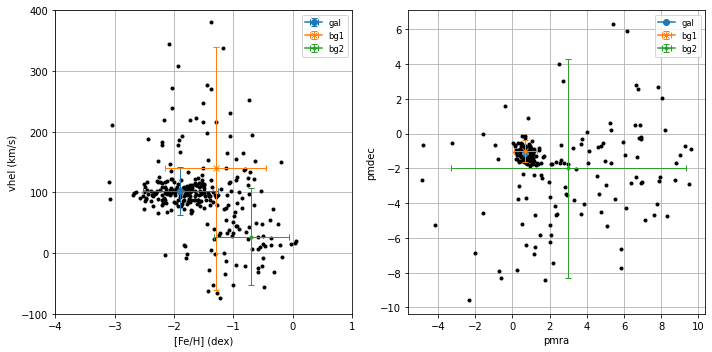

In [64]:
fig1 = plot_1d_distrs(p0_guess)
fig2 = plot_2d_distr(p0_guess)

In [48]:
optfunc = lambda theta: -full_like(theta)

In [49]:
%timeit optfunc(p0_guess)

19.9 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
optfunc(p0_guess)

2766.0810564446065

In [51]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 1min 29s, sys: 227 ms, total: 1min 30s
Wall time: 1min 29s


In [52]:
res.x

array([  0.51822126,   0.14611634,  97.90687384,   1.11059977,
        -1.87697865,  -0.49330645, 142.49968578,   1.72615391,
        -1.87924836,  -0.31524118,  49.99959745,   1.99651687,
        -0.98282561,  -0.31156415,   0.70830808,  -1.13209405,
         0.68053757,  -1.03022774,  -0.43928861,  -0.4397511 ,
         3.23304696,  -2.31389263,   0.49857296,   0.44204178])

In [53]:
optfunc(res.x)

2431.748953097488

In [54]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

pgal: 0.518
pbg1: 0.146
vhel: 97.907
lsigv: 1.111
feh: -1.877
lsigfeh: -0.493
vbg1: 142.500
lsigvbg1: 1.726
fehbg1: -1.879
lsigfeh1: -0.315
vbg2: 50.000
lsigvbg2: 1.997
fehbg2: -0.983
lsigfeh2: -0.312
pmra: 0.708
pmdec: -1.132
pmra1: 0.681
pmdec1: -1.030
lsigpmra1: -0.439
lsigpmdec1: -0.440
pmra2: 3.233
pmdec2: -2.314
lsigpmra2: 0.499
lsigpmdec2: 0.442


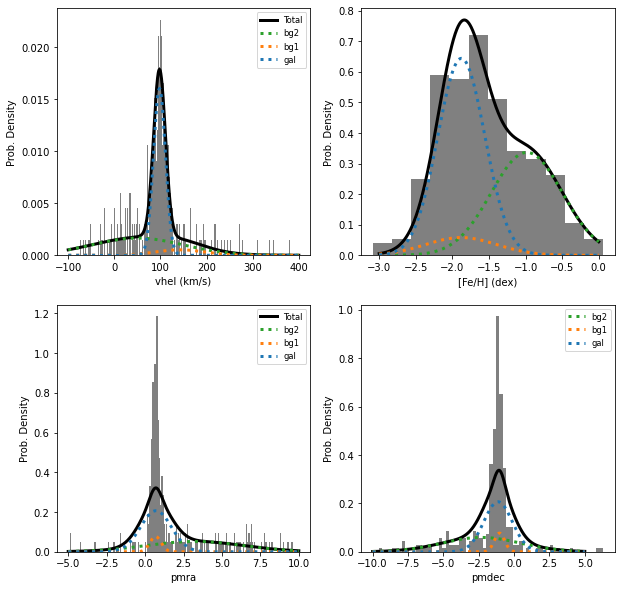

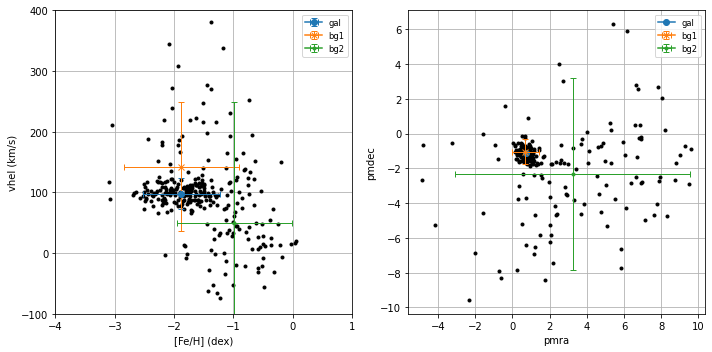

In [63]:
fig1 = plot_1d_distrs(res.x)
fig2 = plot_2d_distr(res.x)

## Posterior Sampling
The posterior is sampled using `emcee` with 64 walkers and 10,000 steps per chain.

In [60]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

24


In [66]:
def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
from schwimmbad import MultiPool
pool = MultiPool(8)
es = emcee.EnsembleSampler(
    nw, len(p0_guess), full_like)

In [67]:
%time PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
es.reset()

CPU times: user 37min 6s, sys: 15.7 s, total: 37min 22s
Wall time: 37min 28s


In [68]:
%time es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
np.save("SMCNOD_PM_2NormalBG.npy",es.flatchain)

CPU times: user 31min 23s, sys: 5.02 s, total: 31min 28s
Wall time: 31min 27s


In [69]:
outputs = es.flatchain

### Acceptance fraction
Judging the convergence and performance of an algorithm is a non-trival problem. As a rule of thumb, the acceptance fraction should be between 0.2 and 0.5 (for example, Gelman, Roberts, & Gilks 1996).

In [70]:
# Another good test of whether or not the sampling went well is to 
# check the mean acceptance fraction of the ensemble
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(es.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.223


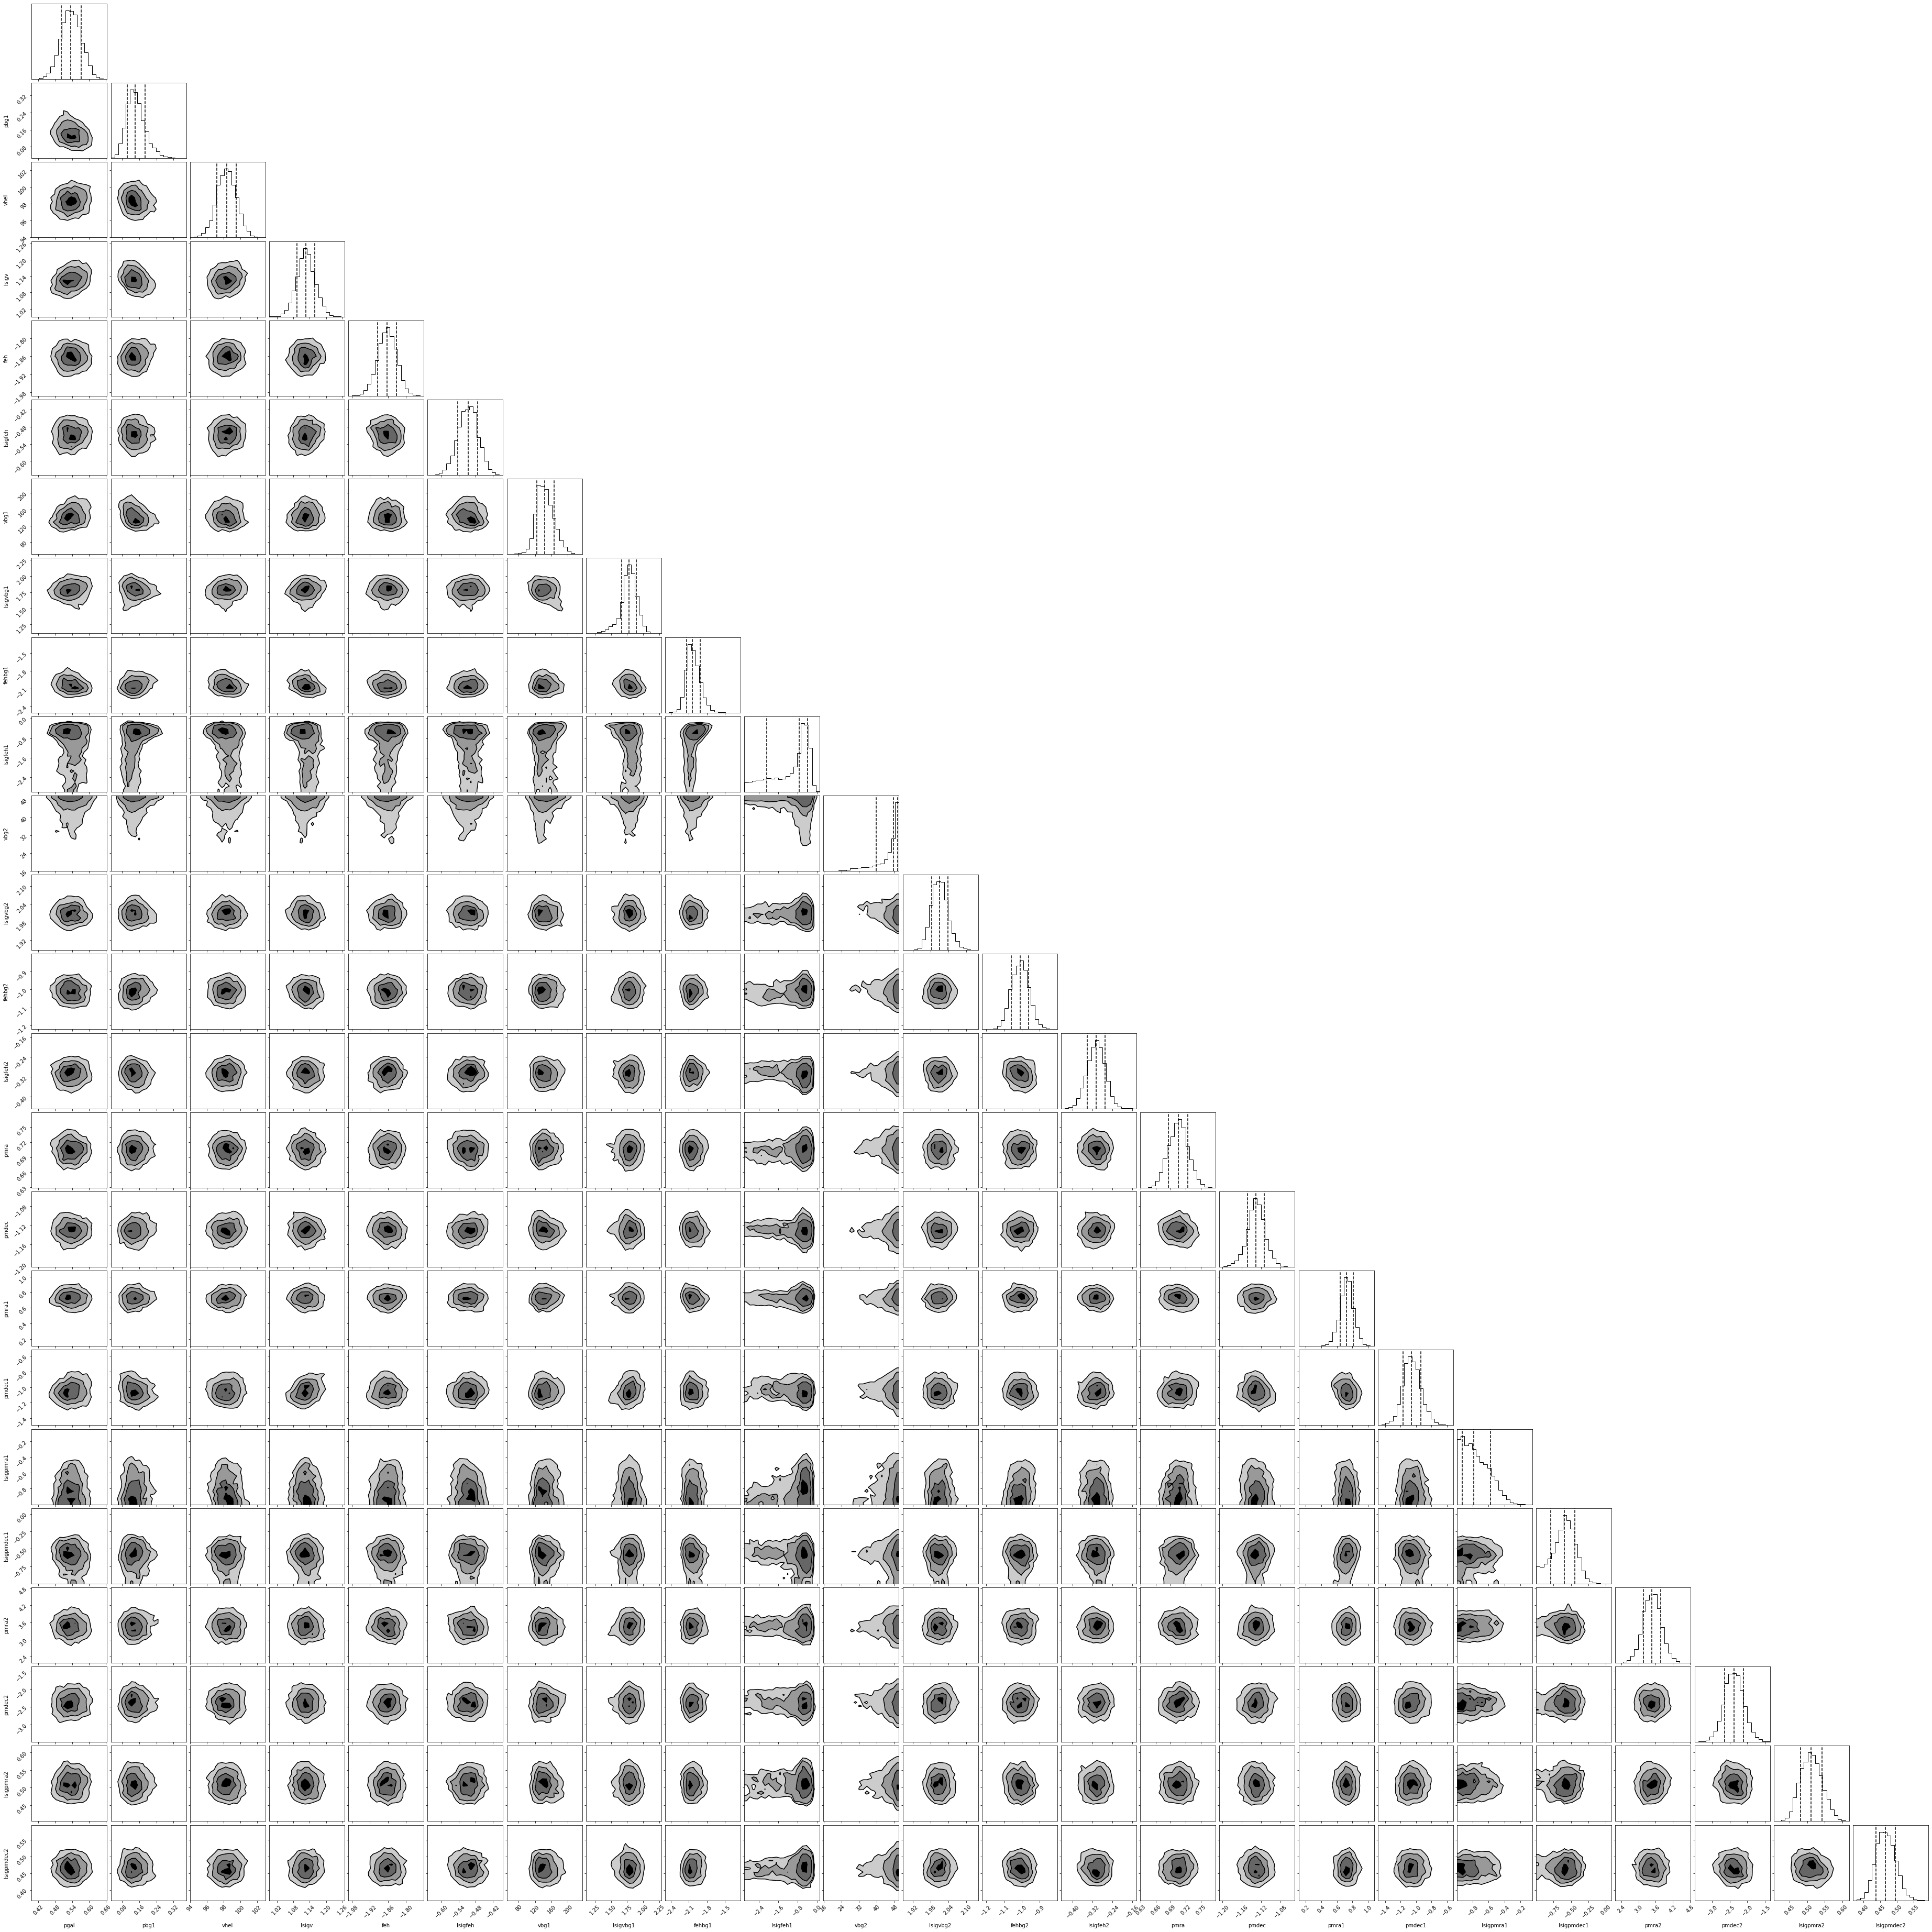

In [71]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})
#plt.savefig('SMCNOD_PM_Model_Cornerplot.png')

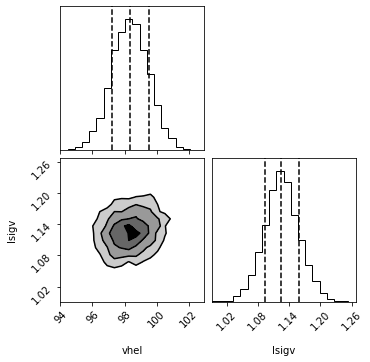

In [72]:
fig1 = corner.corner(outputs[:,2:4], labels=param_labels[2:4], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

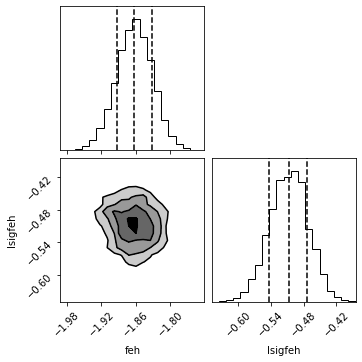

In [73]:
fig2 = corner.corner(outputs[:,4:6], labels=param_labels[4:6], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

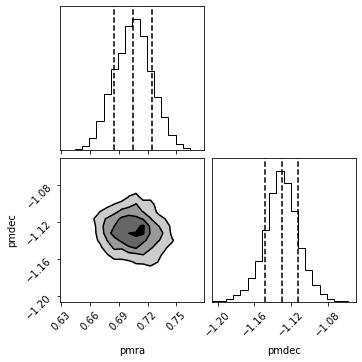

In [74]:
fig3 = corner.corner(outputs[:,14:16], labels=param_labels[14:16], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [75]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [76]:
meds, errs = process_chain(outputs)

In [77]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.536 0.036
pbg1 0.140 0.042
vhel 98.350 1.149
lsigv 1.125 0.033
feh -1.863 0.031
lsigfeh -0.507 0.035
vbg1 142.708 21.242
lsigvbg1 1.782 0.111
fehbg1 -2.040 0.111
lsigfeh1 -0.752 0.834
vbg2 47.509 4.804
lsigvbg2 2.009 0.027
fehbg2 -1.008 0.049
lsigfeh2 -0.306 0.036
pmra 0.705 0.020
pmdec -1.130 0.018
pmra1 0.726 0.084
pmdec1 -1.057 0.113
lsigpmra1 -0.787 0.178
lsigpmdec1 -0.594 0.171
pmra2 3.468 0.311
pmdec2 -2.382 0.271
lsigpmra2 0.511 0.031
lsigpmdec2 0.466 0.029


If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [78]:
chain = es.flatchain
chain.shape

(128000, 24)

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

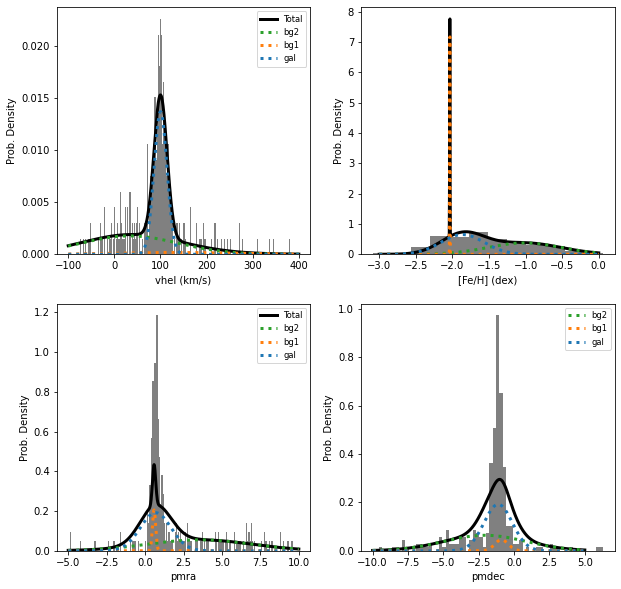

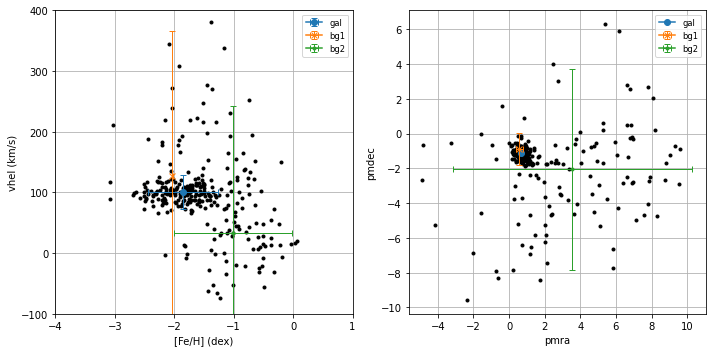

In [79]:
fig1 = plot_1d_distrs(chain[1])
fig2 = plot_2d_distr(chain[1])

In [80]:
chain_new = 10**(chain)
mean_vdisp = np.percentile(chain_new[:,3], 50)
std_vdisp = (np.percentile(chain_new[:,3], 84)-np.percentile(chain_new[:,3], 16))/2
mean_fehdisp = np.percentile(chain_new[:,5], 50)
std_fehdisp = (np.percentile(chain_new[:,5], 84)-np.percentile(chain_new[:,5], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  13.34158077410822 std_vdisp:  1.0210545848861399
mean_fehdisp:  0.31142591029732336 std_fehdisp:  0.02485335802170624


In [81]:
param_labels_1 = ["pgal = ","pbg1 = ",
                "vhel = ","lsigv = ","feh = ","lsigfeh = ",
                "vbg1 = ","lsigvbg1 = ","fehbg1 = ","lsigfeh1 = ",
                "vbg2 = ","lsigvbg2 = ","fehbg2 = ","lsigfeh2 = ",
                "pmra = ","pmdec = ",
                "pmra1 = ","pmdec1 = ","lsigpmra1 = ","lsigpmdec1 = ",
                "pmra2 = ","pmdec2 = ","lsigpmra2 = ","lsigpmdec2 = "]

def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)

for k,v in meds_1.items():
    print("{} {:.3f}".format(k, v))

pgal =  0.536
pbg1 =  0.140
vhel =  98.350
lsigv =  1.125
feh =  -1.863
lsigfeh =  -0.507
vbg1 =  142.708
lsigvbg1 =  1.782
fehbg1 =  -2.040
lsigfeh1 =  -0.752
vbg2 =  47.509
lsigvbg2 =  2.009
fehbg2 =  -1.008
lsigfeh2 =  -0.306
pmra =  0.705
pmdec =  -1.130
pmra1 =  0.726
pmdec1 =  -1.057
lsigpmra1 =  -0.787
lsigpmdec1 =  -0.594
pmra2 =  3.468
pmdec2 =  -2.382
lsigpmra2 =  0.511
lsigpmdec2 =  0.466
